In [2]:
import h5py
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tensorflow.keras.models import clone_model
import pathlib
from tqdm import tqdm
import sys
import os
import pathlib

In [21]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path=f'/content/drive/MyDrive/Colab Notebooks/concept-drift-online'
except:
    root_path = pathlib.Path(f'../').resolve()

In [22]:
attack_vector='network' #cache
machine_setting='static_browser_version' # dynamic_browser_version

data_path=f'{root_path}/data/{machine_setting}/{attack_vector}'
model_0_train_path=f'2021_08_27/train.h5'
hdf5_train_path = (pathlib.Path(data_path)/model_0_train_path).as_posix()


In [23]:
os.getcwd()

'c:\\Users\\tolik\\repos\\concept-drift\\notebooks'

In [24]:
sys.path.append(str(root_path)) # Add the directory to the path
from utils import cnn_lstm,small_cnn_lstm,prepare_hdf5_data,load_hdf5_data,create_subset_encoder,get_data_paths_ordered,predict_on_hdf5

In [25]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [26]:
model_path=f'{data_path}/models/cnn_lstm.keras'
le_dir=f'{data_path}/models/label_encoder_100.pkl'
model0 = tf.keras.models.load_model(model_path)
with open(le_dir, 'rb') as f:
    le = pickle.load(f)

In [29]:
ordered_paths=get_data_paths_ordered(data_path)
batch=256
num_of_classes=100

In [30]:
results={}
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    test_path_i = (path/'test.h5').as_posix()

    # Load data using load_hdf5_data
    X_test_i, y_test_i = load_hdf5_data(test_path_i,le)

    # Prepare data using prepare_hdf5_data with the loaded data
    test_datasets_i = prepare_hdf5_data(X_test_i, y_test_i, batch_size=batch, sample_validation=-1)['data']
    # Make predictions
    all_predictions = []
    all_true_labels = []
    for features, labels in test_datasets_i:
        batch_predictions = model0.predict_on_batch(features)
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels.numpy()) # Convert label tensor to NumPy array

    pred_i = np.concatenate(all_predictions, axis=0)
    y_testi = np.concatenate(all_true_labels, axis=0)

    acci=(y_testi.argmax(axis=1)==pred_i.argmax(axis=1)).mean()
    results.update({curr_date_i:acci})
    print(f'accuracy: {acci}')

  4%|▍         | 1/26 [00:00<00:24,  1.01it/s]

accuracy: 0.9444444444444444


  8%|▊         | 2/26 [00:01<00:21,  1.13it/s]

accuracy: 0.8676767676767677


 12%|█▏        | 3/26 [00:02<00:19,  1.20it/s]

accuracy: 0.8727272727272727


 15%|█▌        | 4/26 [00:03<00:17,  1.23it/s]

accuracy: 0.7878787878787878


 19%|█▉        | 5/26 [00:04<00:16,  1.25it/s]

accuracy: 0.7515151515151515


 23%|██▎       | 6/26 [00:04<00:15,  1.26it/s]

accuracy: 0.7727272727272727


 27%|██▋       | 7/26 [00:05<00:14,  1.27it/s]

accuracy: 0.7282828282828283


 31%|███       | 8/26 [00:06<00:14,  1.27it/s]

accuracy: 0.7414141414141414


 35%|███▍      | 9/26 [00:07<00:13,  1.26it/s]

accuracy: 0.7


 38%|███▊      | 10/26 [00:08<00:12,  1.26it/s]

accuracy: 0.4676767676767677


 42%|████▏     | 11/26 [00:08<00:11,  1.27it/s]

accuracy: 0.6828282828282828


 46%|████▌     | 12/26 [00:09<00:11,  1.27it/s]

accuracy: 0.6424242424242425


 50%|█████     | 13/26 [00:10<00:10,  1.26it/s]

accuracy: 0.7090909090909091


 54%|█████▍    | 14/26 [00:11<00:09,  1.26it/s]

accuracy: 0.7414141414141414


 58%|█████▊    | 15/26 [00:12<00:08,  1.26it/s]

accuracy: 0.6888888888888889


 62%|██████▏   | 16/26 [00:12<00:07,  1.26it/s]

accuracy: 0.6444444444444445


 65%|██████▌   | 17/26 [00:13<00:07,  1.27it/s]

accuracy: 0.6505050505050505


 69%|██████▉   | 18/26 [00:14<00:06,  1.27it/s]

accuracy: 0.6202020202020202


 73%|███████▎  | 19/26 [00:14<00:05,  1.39it/s]

accuracy: 0.6671428571428571


 77%|███████▋  | 20/26 [00:15<00:04,  1.36it/s]

accuracy: 0.6333333333333333


 81%|████████  | 21/26 [00:16<00:03,  1.34it/s]

accuracy: 0.6720812182741117


 85%|████████▍ | 22/26 [00:17<00:03,  1.31it/s]

accuracy: 0.6444444444444445


 88%|████████▊ | 23/26 [00:18<00:02,  1.29it/s]

accuracy: 0.6272727272727273


 92%|█████████▏| 24/26 [00:18<00:01,  1.28it/s]

accuracy: 0.604040404040404


 96%|█████████▌| 25/26 [00:19<00:00,  1.29it/s]

accuracy: 0.14122533748701974


100%|██████████| 26/26 [00:20<00:00,  1.27it/s]

accuracy: 0.6202020202020202


In [32]:
results={}
batch_size=512
n_open_world_labels=30
threshold=0.6

hdf5_train_path = (pathlib.Path(data_path)/'2021_08_27/train.h5').as_posix()

num_of_ow_classes=num_of_classes-n_open_world_labels
X_data, y_data = load_hdf5_data(hdf5_train_path, le, n_samples=-1)
cw_mask=y_data[:,-n_open_world_labels:].any(axis=1)==0
owle=create_subset_encoder(le,num_of_ow_classes)
ow_label=num_of_ow_classes

ow_model_path=f'{data_path}/models/cnn_lstm_ow.keras'
ow_model= tf.keras.models.load_model(ow_model_path)
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    test_path_i = (path/'test.h5').as_posix()
    X_test_i, y_test_i = load_hdf5_data(test_path_i,le)
    test_datasets_i = prepare_hdf5_data(X_test_i, y_test_i[:,:num_of_ow_classes], batch_size=batch, sample_validation=-1,shuffle=True)['data']
    all_predictions = []
    all_true_labels = []
    for features, labels in test_datasets_i:
        batch_predictions = ow_model.predict_on_batch(features)
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels.numpy())

    pred_i = np.concatenate(all_predictions, axis=0)
    pred_cw_mask_i=pred_i.max(axis=1)>=threshold
    pred_cat_i=pred_i.argmax(axis=1)
    pred_cat_i[~pred_cw_mask_i]=ow_label

    y_test_aligned = np.concatenate(all_true_labels, axis=0)
    y_test_cw_mask=y_test_aligned.any(axis=1)
    y_test_aligned_cat=y_test_aligned.argmax(axis=1)
    y_test_aligned_cat[~y_test_cw_mask]=ow_label

    acci=(pred_cat_i==y_test_aligned_cat).mean()
    y_true_indices = y_test_aligned_cat
    y_pred_indices = pred_cat_i
    precision = precision_score(y_true_indices, y_pred_indices, labels=list(range(num_of_ow_classes)), average='weighted')
    recall = recall_score(y_true_indices, y_pred_indices, labels=list(range(num_of_ow_classes)), average='weighted')
    f2score = fbeta_score(y_true_indices, y_pred_indices, beta=2, labels=list(range(num_of_ow_classes)), average='weighted')
    results.update({curr_date_i: {'accuracy': acci, 'precision': precision, 'recall': recall, 'f2score': f2score}})
    print(f'Date: {curr_date_i}, Accuracy: {acci}, Precision (sensitive): {precision}, Recall (sensitive): {recall}, F2-score (sensitive): {f2score}')


  0%|          | 0/26 [00:00<?, ?it/s]c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
  4%|▍         | 1/26 [00:00<00:22,  1.10it/s]

Date: 2021_08_27, Accuracy: 0.7292929292929293, Precision (sensitive): 0.7862951498380584, Recall (sensitive): 0.8847262247838616, F2-score (sensitive): 0.8486213866476436


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
  8%|▊         | 2/26 [00:01<00:19,  1.21it/s]

Date: 2021_09_05, Accuracy: 0.6555555555555556, Precision (sensitive): 0.7079402398251773, Recall (sensitive): 0.7726618705035971, F2-score (sensitive): 0.7371402402928269


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 12%|█▏        | 3/26 [00:02<00:18,  1.25it/s]

Date: 2021_09_12, Accuracy: 0.6565656565656566, Precision (sensitive): 0.6821540427293429, Recall (sensitive): 0.8054755043227666, F2-score (sensitive): 0.7600100193171208


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 15%|█▌        | 4/26 [00:03<00:17,  1.27it/s]

Date: 2021_09_24, Accuracy: 0.6242424242424243, Precision (sensitive): 0.6522290621609764, Recall (sensitive): 0.7377521613832853, F2-score (sensitive): 0.6990963995024448


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 19%|█▉        | 5/26 [00:03<00:16,  1.28it/s]

Date: 2021_09_28, Accuracy: 0.6272727272727273, Precision (sensitive): 0.6607054344480179, Recall (sensitive): 0.707492795389049, F2-score (sensitive): 0.6790505656045416


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 23%|██▎       | 6/26 [00:04<00:16,  1.25it/s]

Date: 2021_10_03, Accuracy: 0.603030303030303, Precision (sensitive): 0.6466495171553397, Recall (sensitive): 0.7093525179856115, F2-score (sensitive): 0.6740299585502154


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 27%|██▋       | 7/26 [00:05<00:15,  1.23it/s]

Date: 2021_10_10, Accuracy: 0.591919191919192, Precision (sensitive): 0.6245796460398214, Recall (sensitive): 0.6623376623376623, F2-score (sensitive): 0.6340742201156845


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 31%|███       | 8/26 [00:06<00:14,  1.22it/s]

Date: 2021_10_17, Accuracy: 0.5777777777777777, Precision (sensitive): 0.6081931664714708, Recall (sensitive): 0.6657060518731989, F2-score (sensitive): 0.6300619583754701


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 35%|███▍      | 9/26 [00:07<00:14,  1.21it/s]

Date: 2021_10_24, Accuracy: 0.5909090909090909, Precision (sensitive): 0.6113993231953649, Recall (sensitive): 0.6829971181556196, F2-score (sensitive): 0.6454232637689736


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 38%|███▊      | 10/26 [00:08<00:13,  1.21it/s]

Date: 2021_10_31, Accuracy: 0.4404040404040404, Precision (sensitive): 0.4960911480763316, Recall (sensitive): 0.42795389048991356, F2-score (sensitive): 0.41251874093906893


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 42%|████▏     | 11/26 [00:08<00:12,  1.21it/s]

Date: 2021_11_07, Accuracy: 0.5313131313131313, Precision (sensitive): 0.5485618233227795, Recall (sensitive): 0.5800865800865801, F2-score (sensitive): 0.5520164810197612


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 46%|████▌     | 12/26 [00:09<00:11,  1.21it/s]

Date: 2021_11_14, Accuracy: 0.5202020202020202, Precision (sensitive): 0.5388745390854824, Recall (sensitive): 0.5576368876080692, F2-score (sensitive): 0.5302674418808986


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 50%|█████     | 13/26 [00:10<00:10,  1.21it/s]

Date: 2021_11_21, Accuracy: 0.5525252525252525, Precision (sensitive): 0.5769250244585046, Recall (sensitive): 0.6095100864553314, F2-score (sensitive): 0.576992636743082


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 54%|█████▍    | 14/26 [00:11<00:09,  1.21it/s]

Date: 2021_11_28, Accuracy: 0.5868686868686869, Precision (sensitive): 0.6386581110540874, Recall (sensitive): 0.6556195965417867, F2-score (sensitive): 0.6304090350143657


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 58%|█████▊    | 15/26 [00:12<00:09,  1.21it/s]

Date: 2021_12_05, Accuracy: 0.5707070707070707, Precision (sensitive): 0.6065583234823134, Recall (sensitive): 0.6368876080691642, F2-score (sensitive): 0.6075344730175064


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 62%|██████▏   | 16/26 [00:13<00:08,  1.21it/s]

Date: 2021_12_12, Accuracy: 0.5484848484848485, Precision (sensitive): 0.5700405277606426, Recall (sensitive): 0.5669064748201439, F2-score (sensitive): 0.5422407620013314


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 65%|██████▌   | 17/26 [00:13<00:07,  1.21it/s]

Date: 2021_12_19, Accuracy: 0.5606060606060606, Precision (sensitive): 0.575336153230217, Recall (sensitive): 0.579250720461095, F2-score (sensitive): 0.5579072794269603


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 69%|██████▉   | 18/26 [00:14<00:06,  1.21it/s]

Date: 2021_12_26, Accuracy: 0.5111111111111111, Precision (sensitive): 0.50267115457665, Recall (sensitive): 0.5345821325648416, F2-score (sensitive): 0.509357989841059


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 73%|███████▎  | 19/26 [00:15<00:05,  1.32it/s]

Date: 2022_01_02, Accuracy: 0.5428571428571428, Precision (sensitive): 0.5423076514721468, Recall (sensitive): 0.5795918367346938, F2-score (sensitive): 0.5484717254669723


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 77%|███████▋  | 20/26 [00:16<00:04,  1.28it/s]

Date: 2022_01_09, Accuracy: 0.5060606060606061, Precision (sensitive): 0.5276988269544991, Recall (sensitive): 0.5273775216138329, F2-score (sensitive): 0.5046258258465505


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 81%|████████  | 21/26 [00:17<00:03,  1.26it/s]

Date: 2022_01_16, Accuracy: 0.550253807106599, Precision (sensitive): 0.5643949282735273, Recall (sensitive): 0.5869565217391305, F2-score (sensitive): 0.5522588428281512


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 85%|████████▍ | 22/26 [00:17<00:03,  1.25it/s]

Date: 2022_01_23, Accuracy: 0.5424242424242425, Precision (sensitive): 0.5307628229518377, Recall (sensitive): 0.5590778097982709, F2-score (sensitive): 0.5263006913954431


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 88%|████████▊ | 23/26 [00:18<00:02,  1.24it/s]

Date: 2022_01_30, Accuracy: 0.498989898989899, Precision (sensitive): 0.5033836738231899, Recall (sensitive): 0.5244956772334294, F2-score (sensitive): 0.4986875351809183


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 92%|█████████▏| 24/26 [00:19<00:01,  1.24it/s]

Date: 2022_02_06, Accuracy: 0.4909090909090909, Precision (sensitive): 0.5131231598382094, Recall (sensitive): 0.5165945165945166, F2-score (sensitive): 0.4881314898249874


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 96%|█████████▌| 25/26 [00:20<00:00,  1.23it/s]

Date: 2022_02_16, Accuracy: 0.181723779854621, Precision (sensitive): 0.09628838854382331, Recall (sensitive): 0.1130952380952381, F2-score (sensitive): 0.09858749412641578


c:\Users\tolik\repos\concept-drift\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
100%|██████████| 26/26 [00:21<00:00,  1.23it/s]

Date: 2022_02_21, Accuracy: 0.5080808080808081, Precision (sensitive): 0.5332565972387215, Recall (sensitive): 0.5266187050359712, F2-score (sensitive): 0.4990945296025345


<Axes: >

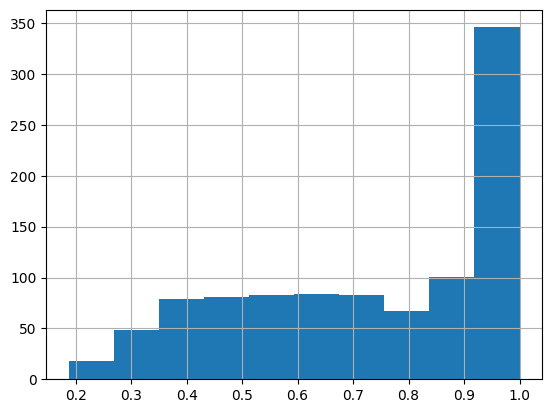

In [35]:
import pandas as pd

pd.Series(pred_i.max(axis=1)).hist()

In [36]:
import json
import pandas as pd
with open(data_path+'/baseline-ow.json','w') as f:
   json.dump(pd.DataFrame(results).to_json(), f)

In [37]:
data_path+'/baseline-ow.json'

'C:\\Users\\tolik\\repos\\concept-drift/data/static_browser_version/network/baseline-ow.json'